# anchors

In [1]:
from lib.layutils.generate_anchors import generate_anchors
import lib.layutils.anchor_target_layer as atl
import torch
import importlib
import numpy as np
importlib.reload(atl)
feat_stride = (16,)
num_anchors = 10
rpn_cls_score = torch.rand(1,3,3,20)
gt_boxes = np.array([[0,4,18,19,1],[16,12,35,42,1]])
im_info = (48,48,1)

def generate_anchors_pre(height, width, feat_stride, anchor_scales=(8,16,32), anchor_ratios=(0.5,1,2)):
    """ A wrapper function to generate anchors given different scales
    Also return the number of anchors in variable 'length'
    """
    anchors = generate_anchors(ratios=np.array(anchor_ratios), scales=np.array(anchor_scales))
    A = anchors.shape[0]
    shift_x = np.arange(0, width) * feat_stride
    shift_y = np.arange(0, height) * feat_stride
    # meshgrid的作用适用于生成网格型数据，可以接受两个一维数组生成两个二维矩阵，对应两个数组中所有的(x,y)对。
    # https://blog.csdn.net/grey_csdn/article/details/69663432
    shift_x, shift_y = np.meshgrid(shift_x, shift_y)    
    # ravel 从多维降为一维, vstack 将数据按行排列，总共为四行， transpose将(4,列) 转成 (列, 4)的偏移量
    shifts = np.vstack((shift_x.ravel(), shift_y.ravel(), shift_x.ravel(), shift_y.ravel())).transpose()  

    K = shifts.shape[0]
    # width changes faster, so here it is H, W, C
    anchors = anchors.reshape((1, A, 4)) + shifts.reshape((1, K, 4)).transpose((1, 0, 2))
    anchors = anchors.reshape((K * A, 4)).astype(np.float32, copy=False)
    length = np.int32(anchors.shape[0])
    return anchors, length

anchors, length = generate_anchors_pre(3, 3,feat_stride=(16,),anchor_scales=(16,))
anchors = anchors.astype(int)

rpn_labels, rpn_bbox_targets, rpn_bbox_inside_weights, rpn_bbox_outside_weights = atl.anchor_target_layer(
    rpn_cls_score.data,
    gt_boxes,
    im_info,
    feat_stride,
    anchors,
    num_anchors)


# smooth_L1_Loss

    https://blog.csdn.net/wfei101/article/details/79252021 损失函数之SmoothL1Loss
    
    
    https://blog.csdn.net/weixin_35653315/article/details/54571681 Single Bounding Box Regression
    
    smooth_L1_Loss 是Faster RCNN提出来的计算距离的loss。输入四个bottom，分别是predict，target，inside_weight, outside_weight 
    

In [20]:
import torch
DEBUG = False
def _smooth_l1_loss(bbox_pred, bbox_targets, bbox_inside_weights, bbox_outside_weights, sigma=1.0, dim=[1]):
    sigma_2 = sigma ** 2
    box_diff = bbox_pred - bbox_targets
    if DEBUG:
        print('box diff --> \n {}'.format(box_diff))
    in_box_diff = bbox_inside_weights * box_diff
    abs_in_box_diff = torch.abs(in_box_diff)
#     if DEBUG:
#         print('abs in box diff --> \n {}'.format(abs_in_box_diff))
        
    smoothL1_sign = (abs_in_box_diff < 1. / sigma_2).detach().float()
    if DEBUG:
        print('smooth l1 sign --> \n {}'.format(smoothL1_sign))
    in_loss_box = torch.pow(in_box_diff, 2) * (sigma_2 / 2.) * smoothL1_sign \
                  + (abs_in_box_diff - (0.5 / sigma_2)) * (1. - smoothL1_sign)
    out_loss_box = bbox_outside_weights * in_loss_box
    loss_box = out_loss_box
    for i in sorted(dim, reverse=True):
        loss_box = loss_box.sum(i)
    loss_box = loss_box.mean()
    return loss_box, abs_in_box_diff

print(rpn_bbox_targets.shape)
# box_pred = torch.randn(1,3,3,40)
# rpn_bbox_targets = torch.from_numpy(rpn_bbox_targets)
print(box_pred)
print(rpn_bbox_targets)

loss,abs_in_box_diff = _smooth_l1_loss(box_pred,rpn_bbox_targets,rpn_bbox_inside_weights,rpn_bbox_outside_weights,3.0,[1,2,3])
print("loss --> {:.4f}".format(loss))

torch.Size([1, 3, 3, 40])
tensor([[[[-1.7481, -0.8570, -1.3375,  1.1948, -0.7803, -0.6211, -0.3676,
           -0.2791,  0.3562,  0.1315, -0.2657, -0.9080,  1.0707, -1.4603,
           -1.4878, -0.6914,  1.4802, -0.5304,  0.9099, -0.8909, -0.1663,
            1.0989, -0.2221,  0.7264, -0.2028, -0.5639, -0.8967,  0.8101,
           -0.0059,  1.0902, -2.3631,  0.4281,  1.5808, -1.0494, -0.3543,
            1.4527,  0.0896,  0.4146,  0.9761, -0.1586],
          [-0.4144,  0.3176, -0.2554,  0.4213,  0.5271, -1.0775,  0.1988,
            1.0974,  1.4605, -0.5038,  0.9624,  0.2028,  0.5765,  0.1185,
           -0.4520,  2.0331, -1.5858, -0.4140,  0.2051, -0.9938,  1.0379,
            1.0532, -0.6513,  1.0371, -1.3853, -0.9805, -0.7451, -1.1747,
           -0.3960,  1.7201,  1.2895, -1.7060,  1.6340,  0.5454, -1.7710,
           -0.2177,  0.3518,  1.1662, -0.1992,  1.0144],
          [-0.9181, -0.8497,  0.3856, -0.4683,  1.8014, -0.0185,  1.6855,
            0.3091, -0.1580,  0.3562, -1.3668,

In [19]:
print((abs_in_box_diff < 1.0/1).detach().float())

tensor([[[[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
            1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
            1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
            1.,  1.,  1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
            1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
            1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
            1.,  1.,  1.,  1.,  1.,  1.,  1.],
          [ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
            1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
            1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
            1.,  1.,  1.,  1.,  1.,  1.,  1.]],

         [[ 1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
            1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
            1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
            1.,  1.,  1.,  1.,  1.,  1.,  1.],
          [ 1.,  1

# data load data

In [8]:
from lib.datasets.factory import get_imdb
from lib.datasets.pascal_voc import pascal_voc
from lib.roi_data_layer.roidb import prepare_roidb
from lib.roi_data_layer.layer import RoIDataLayer
imdb = pascal_voc('trainval', '2007')
# roidb ROI框的坐标位置信息, 信息来源于Annotations目录下对图片的XML定义
prepare_roidb(imdb)   #  为方便训练，在原roidb信息基础上增加象image等等信息
roidb = imdb.roidb 

data_layer = RoIDataLayer(roidb, imdb.num_classes)
blobs = data_layer.forward()
data,im_info,gt_boxes = blobs['data'], blobs['im_info'], blobs['gt_boxes']

<bound method imdb.default_roidb of <lib.datasets.pascal_voc.pascal_voc object at 0x000002768C5A78D0>>
voc_2007_trainval gt roidb loaded from D:\PROJECT_TW\git\data\voc_2007_trainval_gt_roidb.pkl
train image name : num 0 : D:\PROJECT_TW\git\data\VOCdevkit2007\VOC2007\JPEGImages\1.jpg


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(1, 600, 780, 3)
(600, 780, 3)


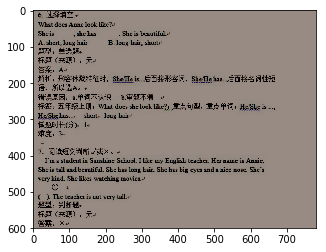

[[[152 139 132]
  [152 138 131]
  [152 137 130]
  ...
  [152 139 132]
  [152 139 132]
  [152 139 132]]

 [[150 139 132]
  [150 139 132]
  [152 139 132]
  ...
  [152 139 132]
  [152 139 132]
  [152 139 132]]

 [[147 139 132]
  [147 139 131]
  [150 139 132]
  ...
  [152 139 132]
  [152 139 132]
  [152 139 132]]

 ...

 [[152 139 132]
  [152 139 132]
  [152 139 132]
  ...
  [152 139 132]
  [152 139 132]
  [152 139 132]]

 [[152 139 132]
  [152 139 132]
  [152 139 132]
  ...
  [152 139 132]
  [152 139 132]
  [152 139 132]]

 [[152 139 132]
  [152 139 132]
  [152 139 132]
  ...
  [152 139 132]
  [152 139 132]
  [152 139 132]]]


In [20]:
import matplotlib.pyplot as plt
import numpy as np
print(data.shape)
ndata = data.reshape(data.shape[1],data.shape[2],data.shape[3])
ndata = ndata.astype(int)
print(ndata.shape)
plt.imshow(ndata,'gray')
plt.show()
print(ndata)

# NMS

# ROI

    https://deepsense.ai/region-of-interest-pooling-in-tensorflow-example/
    https://www.cnblogs.com/king-lps/p/9031568.html

# Cython

    https://www.cnblogs.com/freeweb/p/6548208.html
    https://deepsense.ai/region-of-interest-pooling-in-tensorflow-example/
    https://www.cnblogs.com/king-lps/p/9031568.html

# pytorch 矩阵相乘

In [16]:
import torch
import numpy as np
data = [[1,2], [3,4]]
data2 = [[1,2],[3,1]]
tensor = torch.FloatTensor(data)  # 转换成32位浮点 tensor
tensor2 = torch.FloatTensor(data2)
print(tensor.size(),tensor2.size())
print(data)
print(data2)
# torch.matmul
aa = torch.matmul(tensor, tensor2)  
# correct method
print(aa.size())
print(aa)


torch.Size([2, 2]) torch.Size([2, 2])
[[1, 2], [3, 4]]
[[1, 2], [3, 1]]
torch.Size([2, 2])
tensor([[  7.,   4.],
        [ 15.,  10.]])
